In [152]:
import torch
from pathlib import Path
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from typing import Union, List, Dict, Tuple
from tqdm import tqdm
from torch import nn
import torch.utils.data
import torch.backends.mps
from torch.utils.tensorboard.writer import SummaryWriter
import matplotlib.pyplot as plt
import random

In [153]:
# Setup device-agnostic code
if torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = torch.device("mps" ) # Apple GPU
else:
    device = torch.device("cpu" ) # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available

In [154]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))
    
model = TinyVGG(3, 32, 2).to(device)
model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=2, bias=True)
  )
)

In [198]:
root_dir = Path("/Users/alextsagkas/Document/Office/solar_panels")
result_data = root_dir / "data" / "results"

In [ ]:
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()

test_data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

results_data = datasets.ImageFolder(
    root=str(result_data),
    transform=test_data_transform,
    target_transform=None
)

results_dataloader = DataLoader(
    dataset=results_data,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS if NUM_WORKERS is not None else 1,
    shuffle=False
)

In [209]:
type(results_dataloader)

torch.utils.data.dataloader.DataLoader

In [170]:
class_dict = results_data.class_to_idx
class_names = results_data.classes

class_dict, class_names

({'clean': 0, 'soiled': 1}, ['clean', 'soiled'])

In [171]:
model.load_state_dict(torch.load(f=root_dir / "models" / "tiny_vgg.pth"))

<All keys matched successfully>

In [172]:
imgs, labels = next(iter(results_dataloader))
print(imgs.shape, labels.shape)

torch.Size([1, 3, 64, 64]) torch.Size([1])


Text(0.5, 1.0, 'Truth: clean')

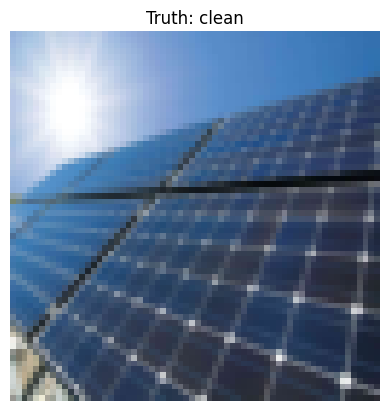

In [207]:
plt.imshow(imgs.squeeze(dim=0).to("cpu").permute(1, 2, 0))
plt.axis(False)
plt.title(f"Truth: {class_names[labels[0]]}")

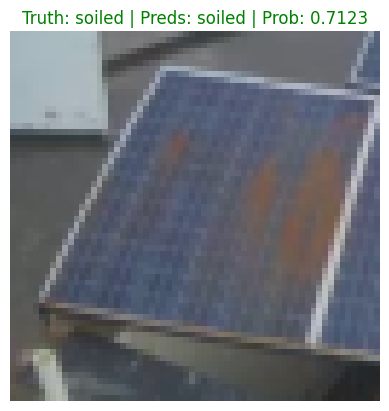

In [208]:
loss_fn = nn.CrossEntropyLoss()

model.eval()
with torch.inference_mode():
    for i, (imgs, labels) in enumerate(results_dataloader):
        imgs, labels = imgs.to(device), labels.to(device)

        preds_logits = model(imgs)
        loss = loss_fn(preds_logits, labels)

        preds = torch.softmax(preds_logits, dim=1).max()
        preds_class = preds_logits.argmax(dim=1)

        prob = f"{preds.item():.4f}" 
        preds_class = class_names[preds_class.item()]
        truth = class_names[labels.item()]  

        plt.imshow(imgs.squeeze().to("cpu").permute(1, 2, 0))
        plt.axis(False)

        title_text = f"Truth: {truth} | Preds: {preds_class} | Prob: {prob}"
        if preds_class == truth:
            plt.title(title_text, color="green")
        else:
            plt.title(title_text, color="red")

        save_folder =  root_dir / "debug" / "test_model" / "tiny_vgg"
        plt.savefig(save_folder / f"{truth}_{preds_class}_{prob}_{i}.png")

Text(0.5, 1.0, 'Truth: clean | Preds: soiled | Prob: 0.9982')

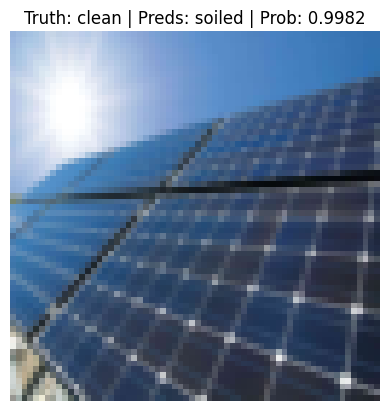

In [193]:
plt.imshow(imgs[0].to("cpu").permute(1, 2, 0))
plt.axis(False)
plt.title(f"Truth: {class_names[labels[0]]} | Preds: {preds_class} | Prob: {prob}")